## Script used for crawling 1000+ images in different car categories

different categories are:

[jeep, cars, lamborigni,luxury cars,audi cars]


#### donot run, it is already done on local machine and the prepared datasets is uploaded to drive


In [0]:
from selenium import webdriver
DRIVER_PATH = "C:/Users/Praveen Kumar/Desktop/chromedriver_win32/chromedriver.exe"
wd = webdriver.Chrome(executable_path=DRIVER_PATH)

import os
import time
import io
from PIL import Image
import hashlib
import requests
from bs4 import BeautifulSoup

def fetch_image_urls(query:str, max_links_to_fetch:int, wd:webdriver, sleep_between_interactions:int=1):
    def scroll_to_end(wd):
        wd.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(sleep_between_interactions)    
    
    # build the google query
    search_url = "https://www.google.com/search?safe=off&site=&tbm=isch&source=hp&q={q}&oq={q}&gs_l=img"

    # load the page
    wd.get(search_url.format(q=query))

    image_urls = set()
    image_count = 0
    results_start = 0
    while image_count < max_links_to_fetch:
        scroll_to_end(wd)

        # get all image thumbnail results
        thumbnail_results = wd.find_elements_by_css_selector("img.rg_ic")
        number_results = len(thumbnail_results)
        
        print(f"Found: {number_results} search results. Extracting links from {results_start}:{number_results}")
        
        for img in thumbnail_results[results_start:number_results]:
            # try to click every thumbnail such that we can get the real image behind it
            try:
                img.click()
                time.sleep(sleep_between_interactions)
            except Exception:
                continue

            # extract image urls    
            actual_images = wd.find_elements_by_css_selector('img.irc_mi')
            for actual_image in actual_images:
                if actual_image.get_attribute('src'):
                    image_urls.add(actual_image.get_attribute('src'))

            image_count = len(image_urls)

            if len(image_urls) >= max_links_to_fetch:
                print(f"Found: {len(image_urls)} image links, done!")
                break
        else:
            print("Found:", len(image_urls), "image links, looking for more ...")
            time.sleep(1)
            load_more_button = wd.find_element_by_css_selector(".ksb")
            if load_more_button:
                wd.execute_script("document.querySelector('.ksb').click();")

        # move the result startpoint further down
        results_start = len(thumbnail_results)

    return image_urls


def persist_image(folder_path:str,url:str):
    try:
        image_content = requests.get(url).content

    except Exception as e:
        print(f"ERROR - Could not download {url} - {e}")

    try:
        image_file = io.BytesIO(image_content)
        image = Image.open(image_file).convert('RGB')
        file_path = os.path.join(folder_path,hashlib.sha1(image_content).hexdigest()[:10] + '.jpg')
        with open(file_path, 'wb') as f:
            image.save(f, "JPEG", quality=85)
        print(f"SUCCESS - saved {url} - as {file_path}")
    except Exception as e:
        print(f"ERROR - Could not save {url} - {e}")

def search_and_download(search_term:str,driver_path:str,target_path='./images',number_images=200):
    target_folder = os.path.join(target_path,'_'.join(search_term.lower().split(' ')))

    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    with webdriver.Chrome(executable_path=driver_path) as wd:
        res = fetch_image_urls(search_term, number_images, wd=wd, sleep_between_interactions=0.5)
        
    for elem in res:
        persist_image(target_folder,elem)


# for cat in ["jeep", "cars", "lamborigni","luxury cars","audi cars"]:
#     term = cat
#     search_and_download(search_term = term,driver_path = DRIVER_PATH)

## Utility functions for handling the crawled data

1. rename_files  function: renames all the files from 0.....N
2. Resize function : converts all the images from any resolution to (100x100)
3. purge function: delete all the other files except the resized images
4. splitfolders : for splitting dataset into 80% training 20% validation sets


#### do not re run, already done on local machine and processed data is uploaded to drive

In [0]:
import os
from PIL import Image

path = "C:/Users/Praveen Kumar/Desktop/data/cars/"

def rename_files(path):
    files = os.listdir(path)
    for index, file in enumerate(files):
        os.rename(os.path.join(path, file), os.path.join(path,"".join([str(index),'.jpg'])))
    
def resize(path):
    files = os.listdir(path)
    for item in files:
        if os.path.isfile(path+item):
            im = Image.open(path+item)
            f, e = os.path.splitext(path+item)
            imResize = im.resize((100,100), Image.ANTIALIAS)
            imResize.save(f+'resized.jpg','JPEG',quality=90)


rename_files(path)
resize(path)


import re

def purge(dir):
    for f in os.listdir(dir):
        if not re.search("resized\.jpg$", f):
            os.remove(os.path.join(dir, f))
            
purge("C:/Users/Praveen Kumar/Desktop/New folder/")  
 

import split_folders
split_folders.ratio("C:/Users/Praveen Kumar/Desktop/New folder/", output="output", seed=1337, ratio=(.8, .2))


### mount drive to load dataset and unzip

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install patool
import patoolib
patoolib.extract_archive("./drive/My Drive/car_data.rar", outdir="./")

     |████████████████████████████████| 81kB 2.6MB/s 
patool: Extracting ./drive/My Drive/car_data.rar ...
patool: running /usr/bin/unrar x -- "/content/drive/My Drive/car_data.rar"
patool:     with cwd='./'
patool: ... ./drive/My Drive/car_data.rar extracted to `./'.


'./'

Data hierarchy 
- Data
  - cars
    - trainA (400)
    - trainB (400)
    - testA (100)
    - testB (100)


### Sample images of cars

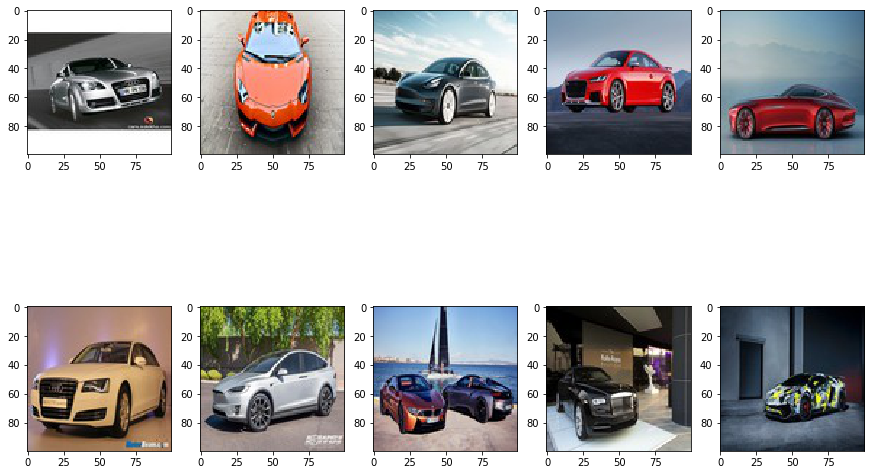

In [3]:
import matplotlib.pyplot as plt
n_row = 2
n_col = 5
k=0
plt.figure(figsize=(15,10))

for j in ["50resized.jpg","100resized.jpg","150resized.jpg","200resized.jpg","250resized.jpg","300resized.jpg","330resized.jpg","59resized.jpg","41resized.jpg","89resized.jpg"]:
  plt.subplot(n_row, n_col, k + 1)
  img  = plt.imread("./data/cars/trainA/{}".format(j))
  plt.imshow(img)
  k = k+1

# CycleGAN training
code from [github link](https://github.com/simontomaskarlsson/CycleGAN-Keras/) which was shared with the assignment

## Load Data

In [4]:
import os
import numpy as np
from PIL import Image
from keras.utils import Sequence
#from skimage.io import imread

def load_data(nr_of_channels=3, batch_size=1, nr_A_train_imgs=None, nr_B_train_imgs=None,
              nr_A_test_imgs=None, nr_B_test_imgs=None, subfolder='cars',
              generator=False, D_model=None, use_multiscale_discriminator=False, use_supervised_learning=False, REAL_LABEL=1.0):

    trainA_path = os.path.join('data', subfolder, 'trainA')
    trainB_path = os.path.join('data', subfolder, 'trainB')
    testA_path = os.path.join('data', subfolder, 'testA')
    testB_path = os.path.join('data', subfolder, 'testB')

    trainA_image_names = os.listdir(trainA_path)
    if nr_A_train_imgs != None:
        trainA_image_names = trainA_image_names[:nr_A_train_imgs]

    trainB_image_names = os.listdir(trainB_path)
    if nr_B_train_imgs != None:
        trainB_image_names = trainB_image_names[:nr_B_train_imgs]

    testA_image_names = os.listdir(testA_path)
    if nr_A_test_imgs != None:
        testA_image_names = testA_image_names[:nr_A_test_imgs]

    testB_image_names = os.listdir(testB_path)
    if nr_B_test_imgs != None:
        testB_image_names = testB_image_names[:nr_B_test_imgs]

    if generator:
        return data_sequence(trainA_path, trainB_path, trainA_image_names, trainB_image_names, batch_size=batch_size)  # D_model, use_multiscale_discriminator, use_supervised_learning, REAL_LABEL)
    else:
        trainA_images = create_image_array(trainA_image_names, trainA_path, nr_of_channels)
        trainB_images = create_image_array(trainB_image_names, trainB_path, nr_of_channels)
        testA_images = create_image_array(testA_image_names, testA_path, nr_of_channels)
        testB_images = create_image_array(testB_image_names, testB_path, nr_of_channels)
        return {"trainA_images": trainA_images, "trainB_images": trainB_images,
                "testA_images": testA_images, "testB_images": testB_images,
                "trainA_image_names": trainA_image_names,
                "trainB_image_names": trainB_image_names,
                "testA_image_names": testA_image_names,
                "testB_image_names": testB_image_names}


def create_image_array(image_list, image_path, nr_of_channels):
    image_array = []
    for image_name in image_list:
        if image_name[-1].lower() == 'g':  # to avoid e.g. thumbs.db files
            if nr_of_channels == 1:  # Gray scale image -> MR image
                image = np.array(Image.open(os.path.join(image_path, image_name)))
                image = image[:, :, np.newaxis]
            else:                   # RGB image -> street view
                image = np.array(Image.open(os.path.join(image_path, image_name)))
            image = normalize_array(image)
            image_array.append(image)

    return np.array(image_array)

# If using 16 bit depth images, use the formula 'array = array / 32767.5 - 1' instead
def normalize_array(array):
    array = array / 127.5 - 1
    return array


class data_sequence(Sequence):

    def __init__(self, trainA_path, trainB_path, image_list_A, image_list_B, batch_size=1):  # , D_model, use_multiscale_discriminator, use_supervised_learning, REAL_LABEL):
        self.batch_size = batch_size
        self.train_A = []
        self.train_B = []
        for image_name in image_list_A:
            if image_name[-1].lower() == 'g':  # to avoid e.g. thumbs.db files
                self.train_A.append(os.path.join(trainA_path, image_name))
        for image_name in image_list_B:
            if image_name[-1].lower() == 'g':  # to avoid e.g. thumbs.db files
                self.train_B.append(os.path.join(trainB_path, image_name))

    def __len__(self):
        return int(max(len(self.train_A), len(self.train_B)) / float(self.batch_size))

    def __getitem__(self, idx):  # , use_multiscale_discriminator, use_supervised_learning):if loop_index + batch_size >= min_nr_imgs:
        if idx >= min(len(self.train_A), len(self.train_B)):
            # If all images soon are used for one domain,
            # randomly pick from this domain
            if len(self.train_A) <= len(self.train_B):
                indexes_A = np.random.randint(len(self.train_A), size=self.batch_size)
                batch_A = []
                for i in indexes_A:
                    batch_A.append(self.train_A[i])
                batch_B = self.train_B[idx * self.batch_size:(idx + 1) * self.batch_size]
            else:
                indexes_B = np.random.randint(len(self.train_B), size=self.batch_size)
                batch_B = []
                for i in indexes_B:
                    batch_B.append(self.train_B[i])
                batch_A = self.train_A[idx * self.batch_size:(idx + 1) * self.batch_size]
        else:
            batch_A = self.train_A[idx * self.batch_size:(idx + 1) * self.batch_size]
            batch_B = self.train_B[idx * self.batch_size:(idx + 1) * self.batch_size]

        real_images_A = create_image_array(batch_A, '', 3)
        real_images_B = create_image_array(batch_B, '', 3)

        return real_images_A, real_images_B  # input_data, target_data


Using TensorFlow backend.


In [5]:
load_data()

{'testA_image_names': ['497resized.jpg',
  '511resized.jpg',
  '525resized.jpg',
  '537resized.jpg',
  '558resized.jpg',
  '494resized.jpg',
  '486resized.jpg',
  '538resized.jpg',
  '529resized.jpg',
  '580resized.jpg',
  '520resized.jpg',
  '498resized.jpg',
  '554resized.jpg',
  '526resized.jpg',
  '521resized.jpg',
  '506resized.jpg',
  '536resized.jpg',
  '504resized.jpg',
  '499resized.jpg',
  '501resized.jpg',
  '513resized.jpg',
  '552resized.jpg',
  '548resized.jpg',
  '573resized.jpg',
  '547resized.jpg',
  '565resized.jpg',
  '523resized.jpg',
  '560resized.jpg',
  '535resized.jpg',
  '541resized.jpg',
  '524resized.jpg',
  '572resized.jpg',
  '502resized.jpg',
  '557resized.jpg',
  '517resized.jpg',
  '579resized.jpg',
  '527resized.jpg',
  '564resized.jpg',
  '556resized.jpg',
  '496resized.jpg',
  '505resized.jpg',
  '488resized.jpg',
  '503resized.jpg',
  '500resized.jpg',
  '578resized.jpg',
  '574resized.jpg',
  '570resized.jpg',
  '493resized.jpg',
  '485resized.jpg',

## Cycle GAN Model

In [6]:
!git clone https://www.github.com/keras-team/keras-contrib.git

Cloning into 'keras-contrib'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 3634 (delta 6), reused 0 (delta 0), pack-reused 3622
Receiving objects: 100% (3634/3634), 862.51 KiB | 1.14 MiB/s, done.
Resolving deltas: 100% (2328/2328), done.


#### installing keras_contrib manually because import was giving weird errors

In [7]:
!python ./keras-contrib/setup.py install

running install
running bdist_egg
running egg_info
creating keras_contrib.egg-info
writing keras_contrib.egg-info/PKG-INFO
writing dependency_links to keras_contrib.egg-info/dependency_links.txt
writing requirements to keras_contrib.egg-info/requires.txt
writing top-level names to keras_contrib.egg-info/top_level.txt
writing manifest file 'keras_contrib.egg-info/SOURCES.txt'
reading manifest file 'keras_contrib.egg-info/SOURCES.txt'
writing manifest file 'keras_contrib.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib

creating build
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/EGG-INFO
copying keras_contrib.egg-info/PKG-INFO -> build/bdist.linux-x86_64/egg/EGG-INFO
copying keras_contrib.egg-info/SOURCES.txt -> build/bdist.linux-x86_64/egg/EGG-INFO
copying keras_contrib.egg-info/dependency_links.txt -> build/bdist.linux-x86_64/egg/EGG-INFO
copying keras_contrib.egg-info/requ

In [0]:
from keras.layers import Layer, Input, Conv2D, Activation, add, BatchNormalization, UpSampling2D, ZeroPadding2D, Conv2DTranspose, Flatten, MaxPooling2D, AveragePooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.backend import mean
from keras.models import Model, model_from_json
from keras.utils import plot_model
from keras.engine.topology import Network

from collections import OrderedDict
# from scipy.misc import imsave, toimage  # has depricated
import numpy as np
import random
import datetime
import time
import json
import math
import csv
import sys
import os

import keras.backend as K
import tensorflow as tf

np.random.seed(seed=12345)

In [0]:
from keras.layers import Layer, InputSpec
from keras import initializers, regularizers, constraints
from keras import backend as K

class InstanceNormalization(Layer):
    """Instance normalization layer.

    Normalize the activations of the previous layer at each step,
    i.e. applies a transformation that maintains the mean activation
    close to 0 and the activation standard deviation close to 1.

    # Arguments
        axis: Integer, the axis that should be normalized
            (typically the features axis).
            For instance, after a `Conv2D` layer with
            `data_format="channels_first"`,
            set `axis=1` in `InstanceNormalization`.
            Setting `axis=None` will normalize all values in each
            instance of the batch.
            Axis 0 is the batch dimension. `axis` cannot be set to 0 to avoid errors.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
            When the next layer is linear (also e.g. `nn.relu`),
            this can be disabled since the scaling
            will be done by the next layer.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.

    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a Sequential model.

    # Output shape
        Same shape as input.

    # References
        - [Layer Normalization](https://arxiv.org/abs/1607.06450)
        - [Instance Normalization: The Missing Ingredient for Fast Stylization](
        https://arxiv.org/abs/1607.08022)
    """
    def __init__(self,
                 axis=None,
                 epsilon=1e-3,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        ndim = len(input_shape)
        if self.axis == 0:
            raise ValueError('Axis cannot be zero')

        if (self.axis is not None) and (ndim == 2):
            raise ValueError('Cannot specify axis for rank 1 tensor')

        self.input_spec = InputSpec(ndim=ndim)

        if self.axis is None:
            shape = (1,)
        else:
            shape = (input_shape[self.axis],)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, training=None):
        input_shape = K.int_shape(inputs)
        reduction_axes = list(range(0, len(input_shape)))

        if self.axis is not None:
            del reduction_axes[self.axis]

        del reduction_axes[0]

        mean = K.mean(inputs, reduction_axes, keepdims=True)
        stddev = K.std(inputs, reduction_axes, keepdims=True) + self.epsilon
        normed = (inputs - mean) / stddev

        broadcast_shape = [1] * len(input_shape)
        if self.axis is not None:
            broadcast_shape[self.axis] = input_shape[self.axis]

        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            normed = normed * broadcast_gamma
        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            normed = normed + broadcast_beta
        return normed

    def get_config(self):
        config = {
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(InstanceNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    

In [0]:
class CycleGAN():
    def __init__(self, lr_D=2e-4, lr_G=2e-4, image_shape=(100*1, 100*1, 3),
                 date_time_string_addition='_test', image_folder='cars'):
        self.img_shape = image_shape
        self.channels = self.img_shape[-1]
        self.normalization = InstanceNormalization
        # Hyper parameters
        self.lambda_1 = 10.0  # Cyclic loss weight A_2_B
        self.lambda_2 = 10.0  # Cyclic loss weight B_2_A
        self.lambda_D = 1.0  # Weight for loss from discriminator guess on synthetic images
        self.learning_rate_D = lr_D
        self.learning_rate_G = lr_G
        self.generator_iterations = 1  # Number of generator training iterations in each training loop
        self.discriminator_iterations = 1  # Number of generator training iterations in each training loop
        self.beta_1 = 0.5
        self.beta_2 = 0.999
        self.batch_size = 1
        self.epochs = 50  # choose multiples of 25 since the models are save each 25th epoch
        self.save_interval = 1
        self.synthetic_pool_size = 50

        # Linear decay of learning rate, for both discriminators and generators
        self.use_linear_decay = False
        self.decay_epoch = 101  # The epoch where the linear decay of the learning rates start

        # Identity loss - sometimes send images from B to G_A2B (and the opposite) to teach identity mappings
        self.use_identity_learning = False
        self.identity_mapping_modulus = 10  # Identity mapping will be done each time the iteration number is divisable with this number

        # PatchGAN - if false the discriminator learning rate should be decreased
        self.use_patchgan = True

        # Multi scale discriminator - if True the generator have an extra encoding/decoding step to match discriminator information access
        self.use_multiscale_discriminator = False

        # Resize convolution - instead of transpose convolution in deconvolution layers (uk) - can reduce checkerboard artifacts but the blurring might affect the cycle-consistency
        self.use_resize_convolution = False

        # Supervised learning part - for MR images - comparison
        self.use_supervised_learning = False
        self.supervised_weight = 10.0

        # Fetch data during training instead of pre caching all images - might be necessary for large datasets
        self.use_data_generator = False

        # Tweaks
        self.REAL_LABEL = 1.0  # Use e.g. 0.9 to avoid training the discriminators to zero loss

        # Used as storage folder name
        self.date_time = time.strftime('%Y%m%d-%H%M%S', time.localtime()) + date_time_string_addition

        # optimizer
        self.opt_D = Adam(self.learning_rate_D, self.beta_1, self.beta_2)
        self.opt_G = Adam(self.learning_rate_G, self.beta_1, self.beta_2)

        # ======= Discriminator model ==========
        if self.use_multiscale_discriminator:
            D_A = self.modelMultiScaleDiscriminator()
            D_B = self.modelMultiScaleDiscriminator()
            loss_weights_D = [0.5, 0.5] # 0.5 since we train on real and synthetic images
        else:
            D_A = self.modelDiscriminator()
            D_B = self.modelDiscriminator()
            loss_weights_D = [0.5]  # 0.5 since we train on real and synthetic images
        # D_A.summary()

        # Discriminator builds
        image_A = Input(shape=self.img_shape)
        image_B = Input(shape=self.img_shape)
        guess_A = D_A(image_A)
        guess_B = D_B(image_B)
        self.D_A = Model(inputs=image_A, outputs=guess_A, name='D_A_model')
        self.D_B = Model(inputs=image_B, outputs=guess_B, name='D_B_model')

        # self.D_A.summary()
        # self.D_B.summary()
        self.D_A.compile(optimizer=self.opt_D,
                         loss=self.lse,
                         loss_weights=loss_weights_D)
        self.D_B.compile(optimizer=self.opt_D,
                         loss=self.lse,
                         loss_weights=loss_weights_D)

        # Use Networks to avoid falsy keras error about weight descripancies
        self.D_A_static = Network(inputs=image_A, outputs=guess_A, name='D_A_static_model')
        self.D_B_static = Network(inputs=image_B, outputs=guess_B, name='D_B_static_model')

        # ======= Generator model ==========
        # Do note update discriminator weights during generator training
        self.D_A_static.trainable = False
        self.D_B_static.trainable = False

        # Generators
        self.G_A2B = self.modelGenerator(name='G_A2B_model')
        self.G_B2A = self.modelGenerator(name='G_B2A_model')
        # self.G_A2B.summary()

        if self.use_identity_learning:
            self.G_A2B.compile(optimizer=self.opt_G, loss='MAE')
            self.G_B2A.compile(optimizer=self.opt_G, loss='MAE')

        # Generator builds
        real_A = Input(shape=self.img_shape, name='real_A')
        real_B = Input(shape=self.img_shape, name='real_B')
        synthetic_B = self.G_A2B(real_A)
        synthetic_A = self.G_B2A(real_B)
        dA_guess_synthetic = self.D_A_static(synthetic_A)
        dB_guess_synthetic = self.D_B_static(synthetic_B)
        reconstructed_A = self.G_B2A(synthetic_B)
        reconstructed_B = self.G_A2B(synthetic_A)

        model_outputs = [reconstructed_A, reconstructed_B]
        compile_losses = [self.cycle_loss, self.cycle_loss,
                          self.lse, self.lse]
        compile_weights = [self.lambda_1, self.lambda_2,
                           self.lambda_D, self.lambda_D]

        if self.use_multiscale_discriminator:
            for _ in range(2):
                compile_losses.append(self.lse)
                compile_weights.append(self.lambda_D)  # * 1e-3)  # Lower weight to regularize the model
            for i in range(2):
                model_outputs.append(dA_guess_synthetic[i])
                model_outputs.append(dB_guess_synthetic[i])
        else:
            model_outputs.append(dA_guess_synthetic)
            model_outputs.append(dB_guess_synthetic)

        if self.use_supervised_learning:
            model_outputs.append(synthetic_A)
            model_outputs.append(synthetic_B)
            compile_losses.append('MAE')
            compile_losses.append('MAE')
            compile_weights.append(self.supervised_weight)
            compile_weights.append(self.supervised_weight)

        self.G_model = Model(inputs=[real_A, real_B],
                             outputs=model_outputs,
                             name='G_model')

        self.G_model.compile(optimizer=self.opt_G,
                             loss=compile_losses,
                             loss_weights=compile_weights)
        # self.G_A2B.summary()

        # ======= Data ==========
        # Use 'None' to fetch all available images
        nr_A_train_imgs = None
        nr_B_train_imgs = None
        nr_A_test_imgs = None
        nr_B_test_imgs = None

        if self.use_data_generator:
            print('--- Using dataloader during training ---')
        else:
            print('--- Caching data ---')
        sys.stdout.flush()

        if self.use_data_generator:            
            self.data_generator = load_data(
                nr_of_channels=self.channels, batch_size=self.batch_size, generator=True, subfolder=image_folder)

            # Only store test images
            nr_A_train_imgs = 0
            nr_B_train_imgs = 0

        data = load_data(nr_of_channels=self.channels,
                                   batch_size=self.batch_size,
                                   nr_A_train_imgs=nr_A_train_imgs,
                                   nr_B_train_imgs=nr_B_train_imgs,
                                   nr_A_test_imgs=nr_A_test_imgs,
                                   nr_B_test_imgs=nr_B_test_imgs,
                                   subfolder=image_folder)

        self.A_train = data["trainA_images"]
        self.B_train = data["trainB_images"]
        self.A_test = data["testA_images"]
        self.B_test = data["testB_images"]
        self.testA_image_names = data["testA_image_names"]
        self.testB_image_names = data["testB_image_names"]
        if not self.use_data_generator:
            print('Data has been loaded')

        # ======= Create designated run folder and store meta data ==========
        directory = os.path.join('images', self.date_time)
        if not os.path.exists(directory):
            os.makedirs(directory)
        self.writeMetaDataToJSON()

        # ======= Avoid pre-allocating GPU memory ==========
        # TensorFlow wizardry
        config = tf.ConfigProto()

        # Don't pre-allocate memory; allocate as-needed
        config.gpu_options.allow_growth = True

        # Create a session with the above options specified.
        K.tensorflow_backend.set_session(tf.Session(config=config))

        # ===== Tests ======
        # Simple Model
#         self.G_A2B = self.modelSimple('simple_T1_2_T2_model')
#         self.G_B2A = self.modelSimple('simple_T2_2_T1_model')
#         self.G_A2B.compile(optimizer=Adam(), loss='MAE')
#         self.G_B2A.compile(optimizer=Adam(), loss='MAE')
#         # self.trainSimpleModel()
#         self.load_model_and_generate_synthetic_images()

        # ======= Initialize training ==========
        sys.stdout.flush()
        #plot_model(self.G_A2B, to_file='GA2B_expanded_model_new.png', show_shapes=True)


        self.train(epochs=self.epochs, batch_size=self.batch_size, save_interval=self.save_interval)
        
        
        
        # self.load_model_and_generate_synthetic_images()

#===============================================================================
# Architecture functions

    def ck(self, x, k, use_normalization, stride):
        x = Conv2D(filters=k, kernel_size=4, strides=stride, padding='same')(x)
        # Normalization is not done on the first discriminator layer
        if use_normalization:
            x = self.normalization(axis=3, center=True, epsilon=1e-5)(x, training=True)
        x = LeakyReLU(alpha=0.2)(x)
        return x

    def c7Ak(self, x, k):
        x = Conv2D(filters=k, kernel_size=7, strides=1, padding='valid')(x)
        x = self.normalization(axis=3, center=True, epsilon=1e-5)(x, training=True)
        x = Activation('relu')(x)
        return x

    def dk(self, x, k):
        x = Conv2D(filters=k, kernel_size=3, strides=2, padding='same')(x)
        x = self.normalization(axis=3, center=True, epsilon=1e-5)(x, training=True)
        x = Activation('relu')(x)
        return x

    def Rk(self, x0):
        k = int(x0.shape[-1])
        # first layer
        x = ReflectionPadding2D((1,1))(x0)
        x = Conv2D(filters=k, kernel_size=3, strides=1, padding='valid')(x)
        x = self.normalization(axis=3, center=True, epsilon=1e-5)(x, training=True)
        x = Activation('relu')(x)
        # second layer
        x = ReflectionPadding2D((1, 1))(x)
        x = Conv2D(filters=k, kernel_size=3, strides=1, padding='valid')(x)
        x = self.normalization(axis=3, center=True, epsilon=1e-5)(x, training=True)
        # merge
        x = add([x, x0])
        return x

    def uk(self, x, k):
        # (up sampling followed by 1x1 convolution <=> fractional-strided 1/2)
        if self.use_resize_convolution:
            x = UpSampling2D(size=(2, 2))(x)  # Nearest neighbor upsampling
            x = ReflectionPadding2D((1, 1))(x)
            x = Conv2D(filters=k, kernel_size=3, strides=1, padding='valid')(x)
        else:
            x = Conv2DTranspose(filters=k, kernel_size=3, strides=2, padding='same')(x)  # this matches fractinoally stided with stride 1/2
        x = self.normalization(axis=3, center=True, epsilon=1e-5)(x, training=True)
        x = Activation('relu')(x)
        return x

#===============================================================================
# Models

    def modelMultiScaleDiscriminator(self, name=None):
        x1 = Input(shape=self.img_shape)
        x2 = AveragePooling2D(pool_size=(2, 2))(x1)
        #x4 = AveragePooling2D(pool_size=(2, 2))(x2)

        out_x1 = self.modelDiscriminator('D1')(x1)
        out_x2 = self.modelDiscriminator('D2')(x2)
        #out_x4 = self.modelDiscriminator('D4')(x4)

        return Model(inputs=x1, outputs=[out_x1, out_x2], name=name)

    def modelDiscriminator(self, name=None):
        # Specify input
        input_img = Input(shape=self.img_shape)
        # Layer 1 (#Instance normalization is not used for this layer)
        x = self.ck(input_img, 64, False, 2)
        # Layer 2
        x = self.ck(x, 128, True, 2)
        # Layer 3
        x = self.ck(x, 256, True, 2)
        # Layer 4
        x = self.ck(x, 512, True, 1)
        # Output layer
        if self.use_patchgan:
            x = Conv2D(filters=1, kernel_size=4, strides=1, padding='same')(x)
        else:
            x = Flatten()(x)
            x = Dense(1)(x)
        #x = Activation('sigmoid')(x) - No sigmoid to avoid near-fp32 machine epsilon discriminator cost
        return Model(inputs=input_img, outputs=x, name=name)

    def modelGenerator(self, name=None):
        # Specify input
        input_img = Input(shape=self.img_shape)
        # Layer 1
        x = ReflectionPadding2D((3, 3))(input_img)
        x = self.c7Ak(x, 32)
        # Layer 2
        x = self.dk(x, 64)
        # Layer 3
        x = self.dk(x, 128)

        if self.use_multiscale_discriminator:
            # Layer 3.5
            x = self.dk(x, 256)

        # Layer 4-12: Residual layer
        for _ in range(4, 13):
            x = self.Rk(x)

        if self.use_multiscale_discriminator:
            # Layer 12.5
            x = self.uk(x, 128)

        # Layer 13
        x = self.uk(x, 64)
        # Layer 14
        x = self.uk(x, 32)
        x = ReflectionPadding2D((3, 3))(x)
        x = Conv2D(self.channels, kernel_size=7, strides=1)(x)
        x = Activation('tanh')(x)  # They say they use Relu but really they do not
        return Model(inputs=input_img, outputs=x, name=name)

#===============================================================================
# Test - simple model
    def modelSimple(self, name=None):
        inputImg = Input(shape=self.img_shape)
        #x = Conv2D(1, kernel_size=5, strides=1, padding='same')(inputImg)
        #x = Dense(self.channels)(x)
        x = Conv2D(256, kernel_size=1, strides=1, padding='same')(inputImg)
        x = Activation('relu')(x)
        x = Conv2D(self.channels, kernel_size=1, strides=1, padding='same')(x)

        return Model(input=inputImg, output=x, name=name)

    def trainSimpleModel(self):
        real_A = self.A_test[0]
        real_B = self.B_test[0]
        real_A = real_A[np.newaxis, :, :, :]
        real_B = real_B[np.newaxis, :, :, :]
        epochs = 200
        for epoch in range(epochs):
            print('Epoch {} started'.format(epoch))
            self.G_A2B.fit(x=self.A_train, y=self.B_train, epochs=1, batch_size=1)
            self.G_B2A.fit(x=self.B_train, y=self.A_train, epochs=1, batch_size=1)
            #loss = self.G_A2B.train_on_batch(x=real_A, y=real_B)
            #print('loss: ', loss)
            synthetic_image_A = self.G_B2A.predict(real_B, batch_size=1)
            synthetic_image_B = self.G_A2B.predict(real_A, batch_size=1)
            self.save_tmp_images(real_A, real_B, synthetic_image_A, synthetic_image_B)

        self.saveModel(self.G_A2B, 200)
        self.saveModel(self.G_B2A, 200)

#===============================================================================
# Training
    def train(self, epochs, batch_size=1, save_interval=1):
        def run_training_iteration(loop_index, epoch_iterations):
            # ======= Discriminator training ==========
                # Generate batch of synthetic images
            synthetic_images_B = self.G_A2B.predict(real_images_A)
            synthetic_images_A = self.G_B2A.predict(real_images_B)
            synthetic_images_A = synthetic_pool_A.query(synthetic_images_A)
            synthetic_images_B = synthetic_pool_B.query(synthetic_images_B)

            for _ in range(self.discriminator_iterations):
                DA_loss_real = self.D_A.train_on_batch(x=real_images_A, y=ones)
                DB_loss_real = self.D_B.train_on_batch(x=real_images_B, y=ones)
                DA_loss_synthetic = self.D_A.train_on_batch(x=synthetic_images_A, y=zeros)
                DB_loss_synthetic = self.D_B.train_on_batch(x=synthetic_images_B, y=zeros)
                if self.use_multiscale_discriminator:
                    DA_loss = sum(DA_loss_real) + sum(DA_loss_synthetic)
                    DB_loss = sum(DB_loss_real) + sum(DB_loss_synthetic)
                    print('DA_losses: ', np.add(DA_loss_real, DA_loss_synthetic))
                    print('DB_losses: ', np.add(DB_loss_real, DB_loss_synthetic))
                else:
                    DA_loss = DA_loss_real + DA_loss_synthetic
                    DB_loss = DB_loss_real + DB_loss_synthetic
                D_loss = DA_loss + DB_loss

                if self.discriminator_iterations > 1:
                    print('D_loss:', D_loss)
                    sys.stdout.flush()

            # ======= Generator training ==========
            target_data = [real_images_A, real_images_B]  # Compare reconstructed images to real images
            if self.use_multiscale_discriminator:
                for i in range(2):
                    target_data.append(ones[i])
                    target_data.append(ones[i])
            else:
                target_data.append(ones)
                target_data.append(ones)

            if self.use_supervised_learning:
                target_data.append(real_images_A)
                target_data.append(real_images_B)

            for _ in range(self.generator_iterations):
                G_loss = self.G_model.train_on_batch(
                    x=[real_images_A, real_images_B], y=target_data)
                if self.generator_iterations > 1:
                    print('G_loss:', G_loss)
                    sys.stdout.flush()

            gA_d_loss_synthetic = G_loss[1]
            gB_d_loss_synthetic = G_loss[2]
            reconstruction_loss_A = G_loss[3]
            reconstruction_loss_B = G_loss[4]

            # Identity training
            if self.use_identity_learning and loop_index % self.identity_mapping_modulus == 0:
                G_A2B_identity_loss = self.G_A2B.train_on_batch(
                    x=real_images_B, y=real_images_B)
                G_B2A_identity_loss = self.G_B2A.train_on_batch(
                    x=real_images_A, y=real_images_A)
                print('G_A2B_identity_loss:', G_A2B_identity_loss)
                print('G_B2A_identity_loss:', G_B2A_identity_loss)

            # Update learning rates
            if self.use_linear_decay and epoch > self.decay_epoch:
                self.update_lr(self.D_A, decay_D)
                self.update_lr(self.D_B, decay_D)
                self.update_lr(self.G_model, decay_G)

            # Store training data
            DA_losses.append(DA_loss)
            DB_losses.append(DB_loss)
            gA_d_losses_synthetic.append(gA_d_loss_synthetic)
            gB_d_losses_synthetic.append(gB_d_loss_synthetic)
            gA_losses_reconstructed.append(reconstruction_loss_A)
            gB_losses_reconstructed.append(reconstruction_loss_B)

            GA_loss = gA_d_loss_synthetic + reconstruction_loss_A
            GB_loss = gB_d_loss_synthetic + reconstruction_loss_B
            D_losses.append(D_loss)
            GA_losses.append(GA_loss)
            GB_losses.append(GB_loss)
            G_losses.append(G_loss)
            reconstruction_loss = reconstruction_loss_A + reconstruction_loss_B
            reconstruction_losses.append(reconstruction_loss)

            if loop_index+1==epoch_iterations:
              print('Epoch----------------', epoch, '/', epochs)
              print('Loop index----------------', loop_index + 1, '/', epoch_iterations)
              print('D_loss: ', D_loss)
              print('G_loss: ', G_loss[0])
              print('reconstruction_loss: ', reconstruction_loss)
              print('dA_loss:', DA_loss)
              print('DB_loss:', DB_loss)

            if loop_index % epoch_iterations == 0:
                # Save temporary images continously
                self.save_tmp_images(real_images_A, real_images_B, synthetic_images_A, synthetic_images_B)
                self.print_ETA(start_time, epoch, epoch_iterations, loop_index)

        # ======================================================================
        # Begin training
        # ======================================================================
        training_history = OrderedDict()

        DA_losses = []
        DB_losses = []
        gA_d_losses_synthetic = []
        gB_d_losses_synthetic = []
        gA_losses_reconstructed = []
        gB_losses_reconstructed = []

        GA_losses = []
        GB_losses = []
        reconstruction_losses = []
        D_losses = []
        G_losses = []

        # Image pools used to update the discriminators
        synthetic_pool_A = ImagePool(self.synthetic_pool_size)
        synthetic_pool_B = ImagePool(self.synthetic_pool_size)

        # self.saveImages('(init)')

        # labels
        if self.use_multiscale_discriminator:
            label_shape1 = (batch_size,) + self.D_A.output_shape[0][1:]
            label_shape2 = (batch_size,) + self.D_A.output_shape[1][1:]
            #label_shape4 = (batch_size,) + self.D_A.output_shape[2][1:]
            ones1 = np.ones(shape=label_shape1) * self.REAL_LABEL
            ones2 = np.ones(shape=label_shape2) * self.REAL_LABEL
            #ones4 = np.ones(shape=label_shape4) * self.REAL_LABEL
            ones = [ones1, ones2]  # , ones4]
            zeros1 = ones1 * 0
            zeros2 = ones2 * 0
            #zeros4 = ones4 * 0
            zeros = [zeros1, zeros2]  # , zeros4]
        else:
            label_shape = (batch_size,) + self.D_A.output_shape[1:]
            ones = np.ones(shape=label_shape) * self.REAL_LABEL
            zeros = ones * 0

        # Linear decay
        if self.use_linear_decay:
            decay_D, decay_G = self.get_lr_linear_decay_rate()

        # Start stopwatch for ETAs
        start_time = time.time()

        for epoch in range(1, epochs + 1):
            if self.use_data_generator:
                loop_index = 1
                for images in self.data_generator:
                    real_images_A = images[0]
                    real_images_B = images[1]
                    if len(real_images_A.shape) == 3:
                        real_images_A = real_images_A[:, :, :, np.newaxis]
                        real_images_B = real_images_B[:, :, :, np.newaxis]

                    # Run all training steps
                    run_training_iteration(loop_index, self.data_generator.__len__())

                    # Store models
                    if loop_index % 20000 == 0:
                        self.saveModel(self.D_A, loop_index)
                        self.saveModel(self.D_B, loop_index)
                        self.saveModel(self.G_A2B, loop_index)
                        self.saveModel(self.G_B2A, loop_index)

                    # Break if loop has ended
                    if loop_index >= self.data_generator.__len__():
                        break

                    loop_index += 1

            else:  # Train with all data in cache
                A_train = self.A_train
                B_train = self.B_train
                random_order_A = np.random.randint(len(A_train), size=len(A_train))
                random_order_B = np.random.randint(len(B_train), size=len(B_train))
                epoch_iterations = max(len(random_order_A), len(random_order_B))
                min_nr_imgs = min(len(random_order_A), len(random_order_B))

                # If we want supervised learning the same images form
                # the two domains are needed during each training iteration
                if self.use_supervised_learning:
                    random_order_B = random_order_A
                for loop_index in range(0, epoch_iterations, batch_size):
                    if loop_index + batch_size >= min_nr_imgs:
                        # If all images soon are used for one domain,
                        # randomly pick from this domain
                        if len(A_train) <= len(B_train):
                            indexes_A = np.random.randint(len(A_train), size=batch_size)

                            # if all images are used for the other domain
                            if loop_index + batch_size >= epoch_iterations:  
                                indexes_B = random_order_B[epoch_iterations-batch_size: 
                                                           epoch_iterations]
                            else: # if not used, continue iterating...
                                indexes_B = random_order_B[loop_index:
                                                           loop_index + batch_size]

                        else: # if len(B_train) <= len(A_train)
                            indexes_B = np.random.randint(len(B_train), size=batch_size)
                            # if all images are used for the other domain
                            if loop_index + batch_size >= epoch_iterations:  
                                indexes_A = random_order_A[epoch_iterations-batch_size: 
                                                           epoch_iterations]
                            else: # if not used, continue iterating...
                                indexes_A = random_order_A[loop_index:
                                                           loop_index + batch_size]
                                
                    else:
                        indexes_A = random_order_A[loop_index:
                                                   loop_index + batch_size]
                        indexes_B = random_order_B[loop_index:
                                                   loop_index + batch_size]

                    sys.stdout.flush()
                    real_images_A = A_train[indexes_A]
                    real_images_B = B_train[indexes_B]

                    # Run all training steps
                    run_training_iteration(loop_index, epoch_iterations)

            #================== within epoch loop end ==========================

            if epoch % save_interval == 0:
                print('\n', '\n', '-------------------------Saving images for epoch', epoch, '-------------------------', '\n', '\n')
                self.saveImages(epoch, real_images_A, real_images_B)

            if epoch % 20 == 0:
                # self.saveModel(self.G_model)
                self.saveModel(self.D_A, epoch)
                self.saveModel(self.D_B, epoch)
                self.saveModel(self.G_A2B, epoch)
                self.saveModel(self.G_B2A, epoch)

            training_history = {
                'DA_losses': DA_losses,
                'DB_losses': DB_losses,
                'gA_d_losses_synthetic': gA_d_losses_synthetic,
                'gB_d_losses_synthetic': gB_d_losses_synthetic,
                'gA_losses_reconstructed': gA_losses_reconstructed,
                'gB_losses_reconstructed': gB_losses_reconstructed,
                'D_losses': D_losses,
                'G_losses': G_losses,
                'reconstruction_losses': reconstruction_losses}
            self.writeLossDataToFile(training_history)

            # Flush out prints each loop iteration
            sys.stdout.flush()

#===============================================================================
# Help functions

    def lse(self, y_true, y_pred):
        loss = tf.reduce_mean(tf.squared_difference(y_pred, y_true))
        return loss

    def cycle_loss(self, y_true, y_pred):
        loss = tf.reduce_mean(tf.abs(y_pred - y_true))
        return loss

    def truncateAndSave(self, real_, real, synthetic, reconstructed, path_name):
        if len(real.shape) > 3:
            real = real[0]
            synthetic = synthetic[0]
            reconstructed = reconstructed[0]

        # Append and save
        if real_ is not None:
            if len(real_.shape) > 4:
                real_ = real_[0]
            image = np.hstack((real_[0], real, synthetic, reconstructed))
        else:
            image = np.hstack((real, synthetic, reconstructed))

        if self.channels == 1:
            image = image[:, :, 0]
        from PIL import Image
        im = Image.fromarray(image,mode='RGB')
        im.save(path_name)

    def saveImages(self, epoch, real_image_A, real_image_B, num_saved_images=1):
        directory = os.path.join('images', self.date_time)
        if not os.path.exists(os.path.join(directory, 'A')):
            os.makedirs(os.path.join(directory, 'A'))
            os.makedirs(os.path.join(directory, 'B'))
            os.makedirs(os.path.join(directory, 'Atest'))
            os.makedirs(os.path.join(directory, 'Btest'))

        testString = ''

        real_image_Ab = None
        real_image_Ba = None
        for i in range(num_saved_images + 1):
            if i == num_saved_images:
                real_image_A = self.A_test[0]
                real_image_B = self.B_test[0]
                real_image_A = np.expand_dims(real_image_A, axis=0)
                real_image_B = np.expand_dims(real_image_B, axis=0)
                testString = 'test'
                
            else:
                #real_image_A = self.A_train[rand_A_idx[i]]
                #real_image_B = self.B_train[rand_B_idx[i]]
                if len(real_image_A.shape) < 4:
                    real_image_A = np.expand_dims(real_image_A, axis=0)
                    real_image_B = np.expand_dims(real_image_B, axis=0)
                
            synthetic_image_B = self.G_A2B.predict(real_image_A)
            synthetic_image_A = self.G_B2A.predict(real_image_B)
            reconstructed_image_A = self.G_B2A.predict(synthetic_image_B)
            reconstructed_image_B = self.G_A2B.predict(synthetic_image_A)

            self.truncateAndSave(real_image_Ab, real_image_A, synthetic_image_B, reconstructed_image_A,
                                 'images/{}/{}/epoch{}_sample{}.png'.format(
                                     self.date_time, 'A' + testString, epoch, i))
            self.truncateAndSave(real_image_Ba, real_image_B, synthetic_image_A, reconstructed_image_B,
                                 'images/{}/{}/epoch{}_sample{}.png'.format(
                                     self.date_time, 'B' + testString, epoch, i))

    def save_tmp_images(self, real_image_A, real_image_B, synthetic_image_A, synthetic_image_B):
        try:
            reconstructed_image_A = self.G_B2A.predict(synthetic_image_B)
            reconstructed_image_B = self.G_A2B.predict(synthetic_image_A)

            real_images = np.vstack((real_image_A[0], real_image_B[0]))
            synthetic_images = np.vstack((synthetic_image_B[0], synthetic_image_A[0]))
            reconstructed_images = np.vstack((reconstructed_image_A[0], reconstructed_image_B[0]))

            self.truncateAndSave(None, real_images, synthetic_images, reconstructed_images,
                                 'images/{}/{}.png'.format(
                                     self.date_time, 'tmp'))
        except: # Ignore if file is open
            pass

    def get_lr_linear_decay_rate(self):
        # Calculate decay rates
        if self.use_data_generator:
            max_nr_images = len(self.data_generator)
        else:
            max_nr_images = max(len(self.A_train), len(self.B_train))

        updates_per_epoch_D = 2 * max_nr_images + self.discriminator_iterations - 1
        updates_per_epoch_G = max_nr_images + self.generator_iterations - 1
        if self.use_identity_learning:
            updates_per_epoch_G *= (1 + 1 / self.identity_mapping_modulus)
        denominator_D = (self.epochs - self.decay_epoch) * updates_per_epoch_D
        denominator_G = (self.epochs - self.decay_epoch) * updates_per_epoch_G
        decay_D = self.learning_rate_D / denominator_D
        decay_G = self.learning_rate_G / denominator_G

        return decay_D, decay_G

    def update_lr(self, model, decay):
        new_lr = K.get_value(model.optimizer.lr) - decay
        if new_lr < 0:
            new_lr = 0
        # print(K.get_value(model.optimizer.lr))
        K.set_value(model.optimizer.lr, new_lr)

    def print_ETA(self, start_time, epoch, epoch_iterations, loop_index):
        passed_time = time.time() - start_time

        iterations_so_far = ((epoch - 1) * epoch_iterations + loop_index) / self.batch_size
        iterations_total = self.epochs * epoch_iterations / self.batch_size
        iterations_left = iterations_total - iterations_so_far
        eta = round(passed_time / (iterations_so_far + 1e-5) * iterations_left)

        passed_time_string = str(datetime.timedelta(seconds=round(passed_time)))
        eta_string = str(datetime.timedelta(seconds=eta))
        print('Time passed', passed_time_string, ': ETA in', eta_string)


#===============================================================================
# Save and load

    def saveModel(self, model, epoch):
        # Create folder to save model architecture and weights
        directory = os.path.join('saved_models', self.date_time)
        if not os.path.exists(directory):
            os.makedirs(directory)

        model_path_w = 'saved_models/{}/{}_weights_epoch_{}.hdf5'.format(self.date_time, model.name, epoch)
        model.save_weights(model_path_w)
        model_path_m = 'saved_models/{}/{}_model_epoch_{}.json'.format(self.date_time, model.name, epoch)
        model.save_weights(model_path_m)
        json_string = model.to_json()
        with open(model_path_m, 'w') as outfile:
            json.dump(json_string, outfile)
        print('{} has been saved in saved_models/{}/'.format(model.name, self.date_time))

    def writeLossDataToFile(self, history):
        keys = sorted(history.keys())
        with open('images/{}/loss_output.csv'.format(self.date_time), 'w') as csv_file:
            writer = csv.writer(csv_file, delimiter=',')
            writer.writerow(keys)
            writer.writerows(zip(*[history[key] for key in keys]))

    def writeMetaDataToJSON(self):

        directory = os.path.join('images', self.date_time)
        if not os.path.exists(directory):
            os.makedirs(directory)
        # Save meta_data
        data = {}
        data['meta_data'] = []
        data['meta_data'].append({
            'img shape: height,width,channels': self.img_shape,
            'batch size': self.batch_size,
            'save interval': self.save_interval,
            'normalization function': str(self.normalization),
            'lambda_1': self.lambda_1,
            'lambda_2': self.lambda_2,
            'lambda_d': self.lambda_D,
            'learning_rate_D': self.learning_rate_D,
            'learning rate G': self.learning_rate_G,
            'epochs': self.epochs,
            'use linear decay on learning rates': self.use_linear_decay,
            'use multiscale discriminator': self.use_multiscale_discriminator,
            'epoch where learning rate linear decay is initialized (if use_linear_decay)': self.decay_epoch,
            'generator iterations': self.generator_iterations,
            'discriminator iterations': self.discriminator_iterations,
            'use patchGan in discriminator': self.use_patchgan,
            'beta 1': self.beta_1,
            'beta 2': self.beta_2,
            'REAL_LABEL': self.REAL_LABEL,
            'number of A train examples': len(self.A_train),
            'number of B train examples': len(self.B_train),
            'number of A test examples': len(self.A_test),
            'number of B test examples': len(self.B_test),
        })

        with open('images/{}/meta_data.json'.format(self.date_time), 'w') as outfile:
            json.dump(data, outfile, sort_keys=True)

    def load_model_and_weights(self, model):
        path_to_model = os.path.join('generate_images', 'models', '{}.json'.format(model.name))
        path_to_weights = os.path.join('generate_images', 'models', '{}.hdf5'.format(model.name))
        #model = model_from_json(path_to_model)
        model.load_weights(path_to_weights)

    def load_model_and_generate_synthetic_images(self):
        response = input('Are you sure you want to generate synthetic images instead of training? (y/n): ')[0].lower()
        if response == 'y':
            self.load_model_and_weights(self.G_A2B)
            self.load_model_and_weights(self.G_B2A)
            synthetic_images_B = self.G_A2B.predict(self.A_test)
            synthetic_images_A = self.G_B2A.predict(self.B_test)
            from PIL import Image  
            def save_image(image, name, domain):
                if self.channels == 1:
                    image = image[:, :, 0]
                im = Image.fromarray(image,mode='RGB')
                im.save(os.path.join('generate_images', 'synthetic_images', domain, name))

            # Test A images
            for i in range(len(synthetic_images_A)):
                # Get the name from the image it was conditioned on
                name = self.testB_image_names[i].strip('.png') + '_synthetic.png'
                synt_A = synthetic_images_A[i]
                save_image(synt_A, name, 'A')

            # Test B images
            for i in range(len(synthetic_images_B)):
                # Get the name from the image it was conditioned on
                name = self.testA_image_names[i].strip('.png') + '_synthetic.png'
                synt_B = synthetic_images_B[i]
                save_image(synt_B, name, 'B')

            print('{} synthetic images have been generated and placed in ./generate_images/synthetic_images'
                  .format(len(self.A_test) + len(self.B_test)))


# reflection padding taken from
# https://github.com/fastai/courses/blob/master/deeplearning2/neural-style.ipynb
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad, h_pad = self.padding
        return tf.pad(x, [[0, 0], [h_pad, h_pad], [w_pad, w_pad], [0, 0]], 'REFLECT')


class ImagePool():
    def __init__(self, pool_size):
        self.pool_size = pool_size
        if self.pool_size > 0:
            self.num_imgs = 0
            self.images = []

    def query(self, images):
        if self.pool_size == 0:
            return images
        return_images = []
        for image in images:
            if len(image.shape) == 3:
                image = image[np.newaxis, :, :, :]

            if self.num_imgs < self.pool_size:  # fill up the image pool
                self.num_imgs = self.num_imgs + 1
                if len(self.images) == 0:
                    self.images = image
                else:
                    self.images = np.vstack((self.images, image))

                if len(return_images) == 0:
                    return_images = image
                else:
                    return_images = np.vstack((return_images, image))

            else:  # 50% chance that we replace an old synthetic image
                p = random.uniform(0, 1)
                if p > 0.5:
                    random_id = random.randint(0, self.pool_size - 1)
                    tmp = self.images[random_id, :, :, :]
                    tmp = tmp[np.newaxis, :, :, :]
                    self.images[random_id, :, :, :] = image[0, :, :, :]
                    if len(return_images) == 0:
                        return_images = tmp
                    else:
                        return_images = np.vstack((return_images, tmp))
                else:
                    if len(return_images) == 0:
                        return_images = image
                    else:
                        return_images = np.vstack((return_images, image))

        return return_images


In [20]:
GAN = CycleGAN()

--- Caching data ---
Data has been loaded
Time passed 0:01:20 : ETA in 1844454 days, 4:29:11
Epoch---------------- 1 / 50
Loop index---------------- 400 / 400
D_loss:  0.5559919
G_loss:  7.769092
reconstruction_loss:  1.1376376
dA_loss: 0.26751938
DB_loss: 0.2884725

 
 -------------------------Saving images for epoch 1 ------------------------- 
 

Time passed 0:03:01 : ETA in 2:27:46
Epoch---------------- 2 / 50
Loop index---------------- 400 / 400
D_loss:  0.28870648
G_loss:  6.919354
reconstruction_loss:  1.6148386
dA_loss: 0.21994188
DB_loss: 0.06876459

 
 -------------------------Saving images for epoch 2 ------------------------- 
 

Time passed 0:04:42 : ETA in 1:52:55
Epoch---------------- 3 / 50
Loop index---------------- 400 / 400
D_loss:  0.36311668
G_loss:  8.328582
reconstruction_loss:  2.0243492
dA_loss: 0.17569761
DB_loss: 0.18741907

 
 -------------------------Saving images for epoch 3 ------------------------- 
 

Time passed 0:06:24 : ETA in 1:40:10
Epoch----------

## CSV Plot file

In [0]:
import csv
import matplotlib.pyplot as plt
import sys
#from operator import add
import numpy as np

from scipy.signal import butter, lfilter, freqz


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


def plotResultfromCSV(datetime, point_gap=1):
    DA_losses = []
    DB_losses = []
    gA_d_losses_synthetic = []
    gB_d_losses_synthetic = []
    gA_losses_reconstructed = []
    gB_losses_reconstructed = []
    D_losses = []
    G_losses = []
    reconstruction_losses = []

    with open('images/{}/loss_output.csv'.format(datetime), newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            DA_losses.append(float(row['DA_losses']))
            DB_losses.append(float(row['DB_losses']))
            gA_d_losses_synthetic.append(float(row['gA_d_losses_synthetic']))
            gB_d_losses_synthetic.append(float(row['gB_d_losses_synthetic']))
            gA_losses_reconstructed.append(float(row['gA_losses_reconstructed']))
            gB_losses_reconstructed.append(float(row['gB_losses_reconstructed']))
            D_losses.append(float(row['D_losses']))
            reconstruction_losses.append(float(row['reconstruction_losses']))
            G_loss = row['G_losses']
            if G_loss[0] == '[':
                G_loss = G_loss.split(',')[0][1:]
            G_losses.append(float(G_loss))
        csvfile.close()

        # Calculate interesting things to plot
        DA_losses = np.array(DA_losses)
        DB_losses = np.array(DB_losses)
        GA_losses = np.add(np.array(gA_d_losses_synthetic), np.array(gA_losses_reconstructed))
        GB_losses = np.add(np.array(gB_d_losses_synthetic), np.array(gB_losses_reconstructed))
        RA_losses = np.array(gA_losses_reconstructed)
        RB_losses = np.array(gB_losses_reconstructed)

        G_losses = np.array(G_losses)
        D_losses = np.array(D_losses)
        reconstruction_losses = np.add(np.array(gA_losses_reconstructed), np.array(gB_losses_reconstructed))

    points = range(0, len(G_losses), point_gap)
    fs = 1000
    cutoff = 2
    order = 6

    # Lowpass filter
    GA = butter_lowpass_filter(GA_losses[points], cutoff, fs, order)
    GB = butter_lowpass_filter(GB_losses[points], cutoff, fs, order)

    DA = butter_lowpass_filter(DA_losses[points], cutoff, fs, order)
    DB = butter_lowpass_filter(DB_losses[points], cutoff, fs, order)

    RA = butter_lowpass_filter(RA_losses[points], cutoff, fs, order)
    RB = butter_lowpass_filter(RB_losses[points], cutoff, fs, order)

    G = butter_lowpass_filter(G_losses[points], cutoff, fs, order)
    D = butter_lowpass_filter(D_losses[points], cutoff, fs, order)
    R = butter_lowpass_filter(reconstruction_losses[points], cutoff, fs, order)

    fig_D = plt.figure(1)
    plt.plot(GA, label='GA_losses')
    plt.plot(GB, label='GB_losses')
    plt.ylabel('Generator losses')
    plt.legend()

    fig_G = plt.figure(2)
    plt.plot(DA, label='DA_losses')
    plt.plot(DB, label='DB_losses')
    plt.ylabel('Discriminator losses')
    plt.legend()

    fig_recons = plt.figure(3)
    plt.plot(RA, label='Reconstruction_loss_A')
    plt.plot(RB, label='Reconstruction_loss_B')
    plt.ylabel('Reconstruction losses')
    plt.legend()

    fig_tots = plt.figure(4)
    plt.plot(G, label='G_losses')
    plt.plot(D, label='D_losses')
    plt.plot(R, label='Reconstruction_losses')
    plt.legend()

    # Show plots
    fig_D.show()
    fig_G.show()
    fig_recons.show()
    fig_tots.show()
    return 

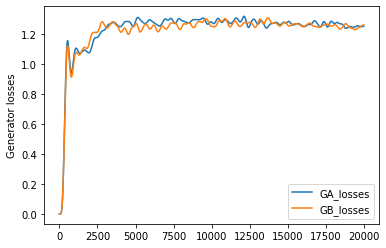

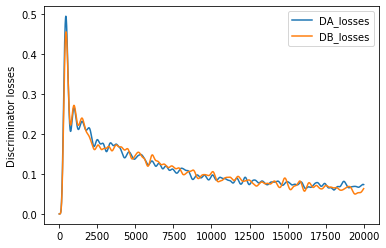

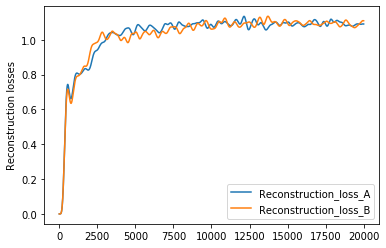

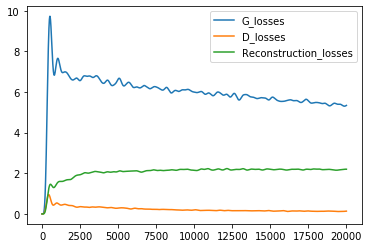

In [38]:
datetime = "20200107-065917_test"
points = 1
plotResultfromCSV(datetime, points)

In [0]:
# !mkdir models
!cp -r ./drive/My\ Drive/generated_images/ ./

In [56]:
GAN = CycleGAN()

--- Caching data ---
Data has been loaded
Are you sure you want to generate synthetic images instead of training? (y/n): y
200 synthetic images have been generated and placed in ./generate_images/synthetic_images


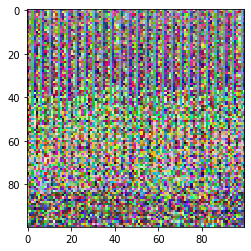

In [60]:
im = plt.imread("generate_images/synthetic_images/A/400resized.j_synthetic.png")
plt.imshow(im)

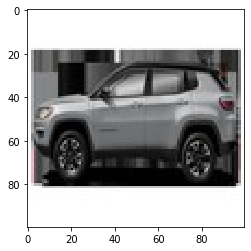

In [61]:
im = plt.imread("generate_images/synthetic_images/B/400resized.jpg")
plt.imshow(im)